#  DeepSet Permutation Equivariant NN for Jet tagging using jet constituents from HLS data implemented by Patrick ( from paper https://arxiv.org/abs/1703.06114 )

##   Original code from: https://github.com/bb511/know_dist

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

In [2]:
import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    


TensorFlow 2.5.0
No GPU available, using CPU !!!


# Load train and test JetID datasets as numpy arrays 

In [1]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]


Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems)



## Define DeepSet NN Models

In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils
from qkeras import *

import tensorflow.keras.layers as KL

class PermutationEquivariantMax(KL.Layer):
    """Permutation equivariant neural network layer with max operation."""

    def __init__(self, dim):
        super(PermutationEquivariantMax, self).__init__()
        self.gamma = KL.Dense(dim)
        self.lambd = KL.Dense(dim, use_bias=False)

    def call(self, inputs: np.ndarray, **kwargs):
        x_maximum = tf.reduce_max(inputs, axis=1, keepdims=True)
        x_maximum = self.lambd(x_maximum)
        x = self.gamma(inputs)
        x = x - x_maximum

        return x


class PermutationEquivariantMean(KL.Layer):
    """Permutation equivariant neural network layer with mean operation."""

    def __init__(self, dim):
        super(PermutationEquivariantMean, self).__init__()
        self.gamma = KL.Dense(dim)                 # multiply features by weights and add bias, sharing the weights and bias. Returns #dim embeded features per element 
        self.lambd = KL.Dense(dim, use_bias=False) # multiply features by weights, sharing the weights over elements. Returns #dim embeded features per element

    def call(self, inputs: np.ndarray, **kwargs):
        x_mean = tf.reduce_mean(inputs, axis=1, keepdims=True) # returns a tensor of size (#elements,#features) containing the mean of each individual feature over elements 
        x_mean = self.lambd(x_mean)   # multiply each mean feature by a weights returning #dim embeded features per element (λI)
        x = self.gamma(inputs)        # returns #dim embeded features per element 
        x = x - x_mean                # get deviation of X from mean features (λI) 

        return x


class DeepSets_Equiv(keras.Model):
    """Deep sets permutation equivariant graph network https://arxiv.org/abs/1703.06114.
    Attributes:
        nnodes_phi: Number of nodes in the layers of the phi neural network.
        nnodes_rho: Number of nodes in the layers of the rho neural network.
        activ: Activation function to use between the dense layers.
    """

    def __init__(self, nnodes_phi: int = 32, nnodes_rho: int = 16, activ: str = "elu"):
        super(DeepSets_Equiv, self).__init__(name="DeepSets_Equiv")
        self.nclasses = 5

        self.phi = keras.Sequential( 
            [
                PermutationEquivariantMean(nnodes_phi),
                KL.Activation(activ),
                PermutationEquivariantMean(nnodes_phi),
                KL.Activation(activ),
                PermutationEquivariantMean(nnodes_phi),
                KL.Activation(activ),
            ]
        ) 

        self.rho = keras.Sequential(
            [
                KL.Dense(nnodes_rho, activation=activ), 
                KL.Dense(self.nclasses)
            ]
        )

    def call(self, inputs: np.ndarray, **kwargs):
        phi_output = self.phi(inputs)                    # put inputs through phi MLP ( permutation invariant layers )
        sum_output = tf.reduce_mean(phi_output, axis=1)  # return mean over elements
        rho_output = self.rho(sum_output)                # put mean over elements through rho MLP returning #classes outputs

        return rho_output


class DeepSets_Inv(keras.Model):
    """Deep sets permutation invariant graph network https://arxiv.org/abs/1703.06114.
    Attributes:
        nnodes_phi: Number of nodes in the layers of the phi neural network.
        nnodes_rho: Number of nodes in the layers of the rho neural network.
        activ: Activation function to use between the dense layers.
    """

    def __init__(self, nnodes_phi: int = 32, nnodes_rho: int = 16, activ: str = "elu"):
        super(DeepSets_Inv, self).__init__(name="DeepSets_Inv")
        self.nclasses = 5

        self.phi = keras.Sequential(
            [
                KL.Dense(nnodes_phi),
                KL.Activation(activ),
                KL.Dense(nnodes_phi),
                KL.Activation(activ),
                KL.Dense(nnodes_phi),
                KL.Activation(activ),
            ]
        )

        self.rho = keras.Sequential(
            [
                KL.Dense(nnodes_rho, activation=activ),
                KL.Dense(self.nclasses)
            ]
        )

    def call(self, inputs: np.ndarray, **kwargs):
        phi_output = self.phi(inputs)
        sum_output = tf.reduce_mean(phi_output, axis=1)
        rho_output = self.rho(sum_output)

        return rho_output

In [35]:
#########################################################################################################
'''
# Silence the info from tensorflow in which it brags that it can run on cpu nicely.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
keras.utils.set_random_seed(123)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from util.terminal_colors import tcols
from . import util as dsutil

tf.keras.backend.set_floatx("float64")

util.util.device_info()
outdir = util.util.make_output_directory("trained_deepsets", args["outdir"])
util.util.save_hyperparameters_file(args, outdir)

data = Data.shuffled(**args["data_hyperparams"])
'''
#########################################################################################################

nnodes_phi = 32
nnodes_rho = 16
activ      = "elu"

# Number of target classes
nclasses = len(Y_train_val[0]) 

# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
#inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format


# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm')(inp)



#####################

# Phi MLP ( permutation equivariant layers )

# Equivariant Layer 1
x_mean = GlobalAveragePooling1D(name='avgpool_1')(h)          # returns a tensor of size (#elements,#features) containing the mean of each individual feature over elements 
x_mean = Reshape((1,3),name='reshap_1')(x_mean)      # reshape tensor to original 3D format (batch, 1, nfeat)
x_mean = Dense(nnodes_phi, use_bias=False, name='densenobias_1')(x_mean) # multiply features by weights, sharing the weights over elements. Returns #dim embeded features per element   # multiply each mean feature by a weights returning #dim embeded features per element (λI)
x = Dense(nnodes_phi, name='dense_1')(h)                      # multiply features by weights and add bias, sharing the weights and bias. Returns #dim embeded features per element
h = x - x_mean                                                # get deviation of X from mean features (λI) 
phi_out = Activation(activ)(h)

# Equivariant Layer 2
x_mean = GlobalAveragePooling1D(name='avgpool_2')(h)          # returns a tensor of size (#elements,#features) containing the mean of each individual feature over elements 
x_mean = Reshape((1,32),name='reshap_2')(x_mean)      # reshape tensor to original 3D format (batch, 1, nfeat)
x_mean = Dense(nnodes_phi, use_bias=False, name='densenobias_2')(x_mean) # multiply features by weights, sharing the weights over elements. Returns #dim embeded features per element   # multiply each mean feature by a weights returning #dim embeded features per element (λI)
x = Dense(nnodes_phi, name='dense_2')(h)                      # multiply features by weights and add bias, sharing the weights and bias. Returns #dim embeded features per element
h = x - x_mean                                                # get deviation of X from mean features (λI) 
phi_out = Activation(activ)(h)

#####################

# Agregate features (taking mean) over set elements  
mean = GlobalAveragePooling1D(name='avgpool_phi')(phi_out)      # return mean of features over elements
#mean = tf.reduce_mean(phi_out, axis=1)                        # return mean of features over elements
 
# Rho MLP
h = Dense(nnodes_rho, name='denserho_1')(mean)
h = Activation(activ)(h)
h = Dense(nclasses, name='denserho_2')(h)
out = Activation('softmax',name='softmax_g')(h)


# Build the model
arch  = 'DeepSets_PermutationEquiv'
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
#optim = Adam(learning_rate=0.0001)
optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
BatchNorm (BatchNormalization)  (None, 32, 3)        12          inp[0][0]                        
__________________________________________________________________________________________________
avgpool_1 (GlobalAveragePooling (None, 3)            0           BatchNorm[0][0]                  
__________________________________________________________________________________________________
reshap_1 (Reshape)              (None, 1, 3)         0           avgpool_1[0][0]                  
____________________________________________________________________________________________

## Run training

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('DeepSet_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit( X_train_val, Y_train_val, 
                    epochs=20, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
 
#
# Set NN and output name
fname = arch+'_nconst_'+str(nmax)
print('Saving Model : ',fname)


# Save the model
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
#model.save_weights('weights_'+fname+'.h5')

Epoch 1/20
807/807 [==============================] - 6s 7ms/step - loss: 1.1890 - categorical_accuracy: 0.5199 - val_loss: 1.0616 - val_categorical_accuracy: 0.5846
Epoch 2/20
807/807 [==============================] - 5s 6ms/step - loss: 1.0134 - categorical_accuracy: 0.6032 - val_loss: 0.9733 - val_categorical_accuracy: 0.6239
Epoch 3/20
807/807 [==============================] - 5s 6ms/step - loss: 0.9462 - categorical_accuracy: 0.6359 - val_loss: 0.9277 - val_categorical_accuracy: 0.6454
Epoch 4/20
807/807 [==============================] - 5s 6ms/step - loss: 0.9160 - categorical_accuracy: 0.6516 - val_loss: 0.9045 - val_categorical_accuracy: 0.6556
Epoch 5/20
807/807 [==============================] - 5s 6ms/step - loss: 0.9004 - categorical_accuracy: 0.6585 - val_loss: 0.8974 - val_categorical_accuracy: 0.6535
Epoch 6/20
807/807 [==============================] - 5s 6ms/step - loss: 0.8908 - categorical_accuracy: 0.6631 - val_loss: 0.8873 - val_categorical_accuracy: 0.6661
Epoc

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


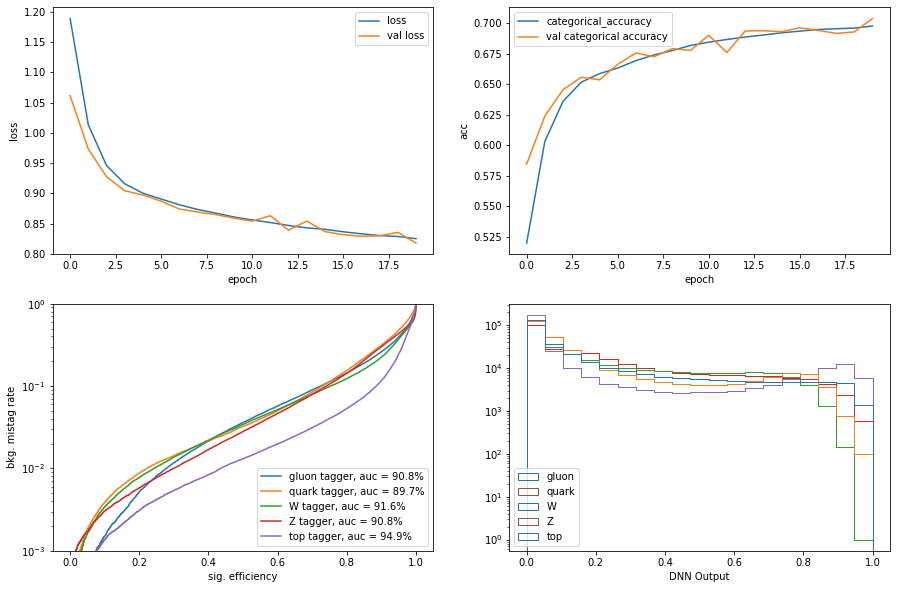

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')


# Display plots
fig = plt.gcf()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)



# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)


'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''

'''
# Save a sample of events for HLS
njets=3000
print(X_test.shape)
np.save('x_test.npy', X_test[0:njets,:])
np.save('y_test.npy', Y_test[0:njets,:])
'''

Label =  gluon  with treshold =  0.3
TPR =  0.30005302499016473
FPR =  0.011697141896290803
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000256572533055
FPR =  0.036177927626898684
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000102629013222
FPR =  0.14399168739787097
 
Label =  quark  with treshold =  0.3
TPR =  0.3000141582896786
FPR =  0.0143097787050655
 
Label =  quark  with treshold =  0.5
TPR =  0.5000530935862948
FPR =  0.03233915928446831
 
Label =  quark  with treshold =  0.8
TPR =  0.8000141582896786
FPR =  0.1551629784177583
 
Label =  W  with treshold =  0.3
TPR =  0.3000154302467125
FPR =  0.013706893951472166
 
Label =  W  with treshold =  0.5
TPR =  0.5000085723592848
FPR =  0.03423491746131605
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.12354733208947184
 
Label =  Z  with treshold =  0.3
TPR =  0.3001011364999914
FPR =  0.010057613665254693
 
Label =  Z  with treshold =  0.5
TPR =  0.5000085708898298
FPR =  0.028048417886522195
 
Labe

"\n# Save a sample of events for HLS\nnjets=3000\nprint(X_test.shape)\nnp.save('x_test.npy', X_test[0:njets,:])\nnp.save('y_test.npy', Y_test[0:njets,:])\n"